# Clustering (Jan 2020 version)
- Last Edit: 01/17/2020
- note: two step clustering so that New England is not too big of a market 

## Overview



input: 
- coordinates : dec13_total_df.csv 
- parameters for OPTICS 

Outputs: 
- labeled coordinates :   es_labeled'+parameters+'.csv'
- coordinates graph for illustration



In [1]:
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
import csv 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import OPTICS
from sklearn.neighbors import DistanceMetric
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

import geopandas as gpd

from shapely.geometry import Point, Polygon, MultiPoint
import matplotlib.pyplot as plt

### Version 
Use string version and use this in output file name string

In [2]:
version='dec_06'

### Import data for clustering 

In [3]:
import os 
import pandas as pd
#os.chdir('C:/Users/herbi/Google Drive/Current_SolarResearch/working_estimation_august')
total_df_url='C:/Users/Herbie Huang/Google Drive/Current_SolarResearch/working_oct/dec14_total_df.csv' 
total_df=pd.read_csv(total_df_url)
#total_coords=get_coords(total_df)

### Helper functions

#### helper function get_coords - two versions: dropdup vs not dropdup 

In [4]:
def get_coords( dataframe ):
    #df=dataframe[['installerid','lat','long']]
    df=dataframe[['lat','long']]
    df=df.dropna().drop_duplicates()
    coords=df.as_matrix(columns=['lat','long'])
    return coords;



In [5]:
def get_coords_dropdup( dataframe ):
    #df=dataframe[['installerid','lat','long']]
    df=dataframe[['lat','long']]
    df=df.dropna().drop_duplicates()
    coords=df.as_matrix(columns=['lat','long'])
    return coords;



#### Helper Function: Get Centroid

In [6]:
def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.y, MultiPoint(cluster).centroid.x)
    return tuple(centroid)

#### Helper Function: Haversine distance

In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

##  Define the OPTICS routine
Notice: min_sample is the humber of samples ina neighborfhood for a point to be considered as a core point. This is to be
 
### important parameters for OPTICS
#### Parameters:  	
* __min_samples__ : int (default=5)
The number of samples in a neighborhood for a point to be considered as a core point.

* __max_eps__ : float, optional (default=np.inf)
The maximum distance between two samples for them to be considered as in the same neighborhood. Default value of “np.inf” will identify clusters across all scales; reducing max_eps will result in shorter run times.  
* __eps__: float, optional (default=0.5)
The maximum distance between two samples for them to be considered as in the same neighborhood. Used ony when cluster_method='dbscan  

#### Outputs:
* include the silhouette score and calinski-harabasz score
* and the cluster object op and parameters 
#### Data Inputs:  
__coords__: coordinates 

In [8]:
def optics_coords_v2(radius,max_ep,min_size,coords):
    kms_per_radian = 6371.0088
    epsilon = radius / kms_per_radian
    print('ready to cluster with radius= '+str(radius)+'max_ep: '+str(max_ep)+' and min_size: '+str(min_size))
    op=OPTICS(min_samples=min_size, max_eps=max_ep, metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1], p=2,
                 metric_params=None, cluster_method='dbscan', eps=epsilon, algorithm='ball_tree', leaf_size=30,
                 n_jobs=None).fit(np.radians(coords))
    #print('we are done clustering...just computing the sil score')
    sil_score=metrics.silhouette_score(coords, op.labels_,metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1])        
    #print('the sil score is '+str(sil_score))
    labels = op.labels_
    X =coords
    cal_score=metrics.calinski_harabasz_score(X, labels) 
    cluster_num=len(set(labels))
    return [op,radius,min_size,sil_score,cal_score,cluster_num]

### Helper function: Plot only function

In [41]:
def plot_coordinates_us(coords):
    mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)
    
    coords_df=pd.DataFrame()
    coords_df['Coordinates']=tuple(zip(coords['long'],coords['lat']))
    coords_df['Coordinates']=coords_df
    coords_df['Coordinates']=coords_df['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    gdf=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
    
    plt.savefig('testplot')
    plt.show()
    

### Helper function: Cluster and Plot function

In [43]:
def cluster_and_plot(radius, max_eps,min_size,coords):
# run the optics 
    optics_run=optics_coords_v2(radius,max_eps,min_size,coords)
# collect cluster results  
    temp_reduced_optics_output=pd.DataFrame(columns=['labels','lat','long'])
    temp_reduced_optics_output['labels']=optics_run[0].labels_
    temp_reduced_optics_output['lat']=coords[:,0]
    temp_reduced_optics_output['long']=coords[:,1]
#find centroid for plotting 
    total_cluster_ct=[]
    for label in set(temp_reduced_optics_output.labels):
        #print(label)
        temp_centroid=get_centroid(get_coords(temp_reduced_optics_output[temp_reduced_optics_output['labels']==label]))
        total_cluster_ct=total_cluster_ct+[temp_centroid]

    cluster_centroids=pd.DataFrame()
    cluster_centroids['Coordinates']=total_cluster_ct
    cluster_centroids['Coordinates']=cluster_centroids['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)

    gdf=gpd.GeoDataFrame(cluster_centroids,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
   
    plt.savefig('testplot.jpg')
    plt.show()
    # output : the labeled original coords 
    #temp_output=pd.DataFrame(columns=['labels','lat','long'])
    #temp_output['labels']=optics_run_total[0].labels_
    #temp_output['lat']=total_df_reduced[:,0]
    #temp_output['long']=total_df_reduced[:,1]
 # return the original results 
    return optics_run

## Data Exploration

### Plot the ES installers alone

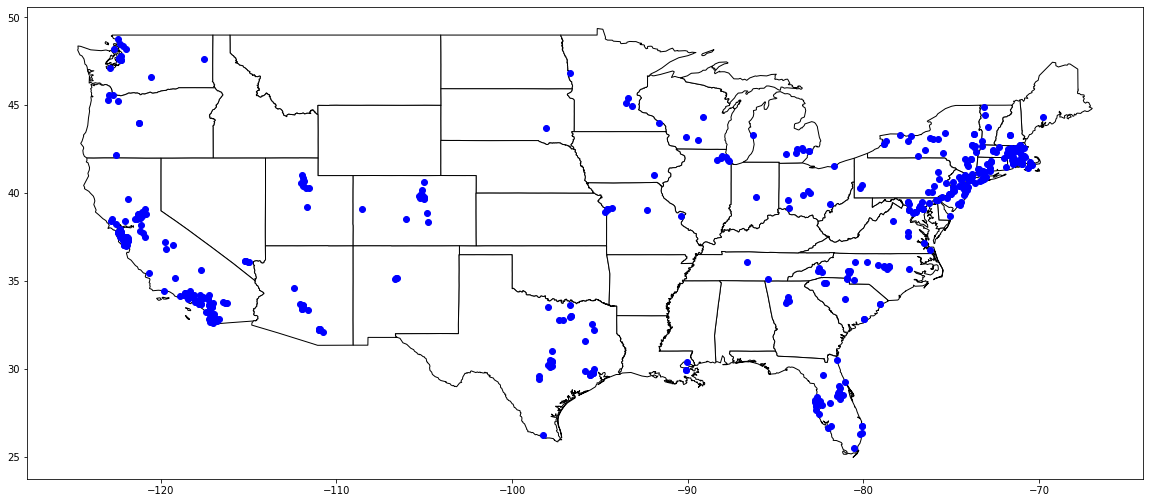

In [42]:
plot_coordinates_us(total_df[total_df['isES']==1])

### sample: a cluster routine 

get coordinates for clustering

In [13]:
es_coords=get_coords(total_df[total_df['isES']==1])



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Run the cluster and plot function

ready to cluster with radius= 90max_ep: 100 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


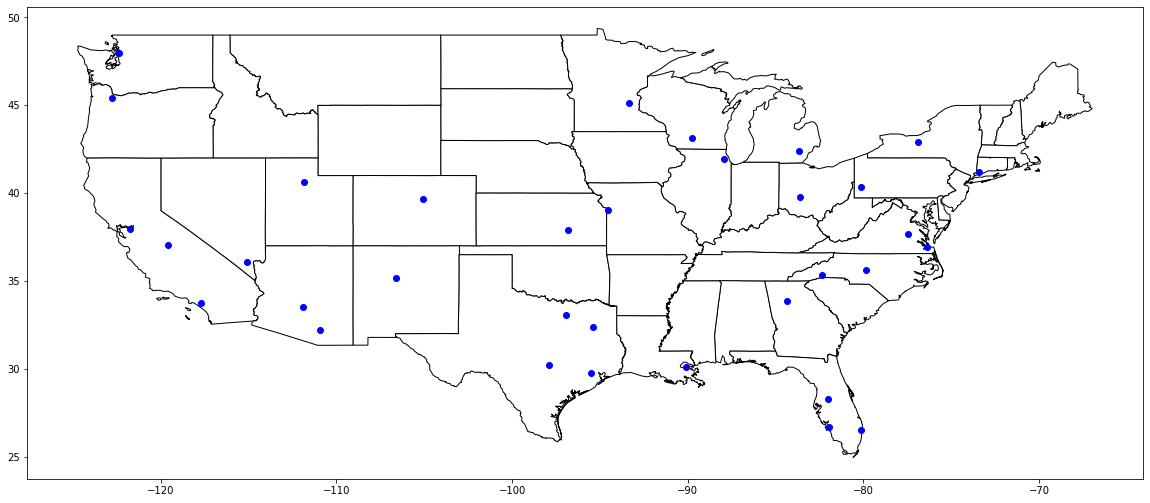

In [44]:
cluster_es=cluster_and_plot(90,100,2,es_coords)

## The highest Cal score clustering

In [15]:
es_coords=get_coords(total_df[total_df['isES']==1])



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 90max_ep: 100 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


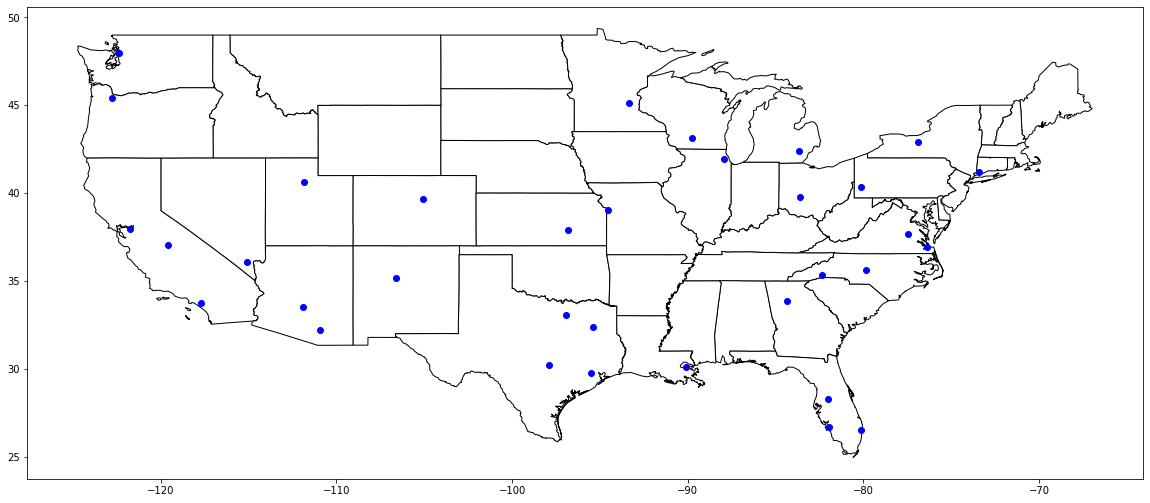

<Figure size 432x288 with 0 Axes>

In [16]:
cluster_es=cluster_and_plot(90,100,2,es_coords)

### Note the problem 
is that although California has reasonable number of clusters, New England is essentially one blob

## Tidy up and export the clustering result 


In [17]:
es_labeled=pd.DataFrame(columns=['labels','lat','long'])
es_labeled['labels']=cluster_es[0].labels_
es_labeled['lat']=es_coords[:,0]
es_labeled['long']=es_coords[:,1]
es_labeled.head()

,labels,lat,long
0,0,45.569080,-122.946701
1,14,42.503670,-83.781059
2,4,34.004478,-117.684700
3,6,33.610741,-111.891472
4,30,29.985395,-95.346214


In [18]:
parameters='90_100_2'
es_labeled.to_csv('es_labeled'+parameters+'.csv')

## produce the cluster diameter distance 

In [19]:
import pandas as pd
parameters='90_100_2'
es_labeled=pd.read_csv('es_labeled'+parameters+'.csv')

In [20]:
es_labeled.head()

,Unnamed: 0,labels,lat,long
0,0,0,45.569080,-122.946701
1,1,14,42.503670,-83.781059
2,2,4,34.004478,-117.684700
3,3,6,33.610741,-111.891472
4,4,30,29.985395,-95.346214


In [21]:
def get_distance_from_index(cluster,index_pair):
    la1,long1,la2,long2=cluster.iloc[index_pair[0]].lat,a_cluster.iloc[index_pair[0]].long,a_cluster.iloc[index_pair[1]].lat,a_cluster.iloc[index_pair[1]].long
    distance=haversine(la1,long1,la2,long2)
    return distance


In [22]:
a_cluster=es_labeled[es_labeled['labels']==2].drop_duplicates()
a_cluster

,Unnamed: 0,labels,lat,long
10,10,2,38.562202,-121.204697
22,22,2,37.516899,-121.911751
50,50,2,38.161880,-121.149834
83,83,2,38.543850,-121.378281
84,84,2,38.554485,-121.497055
85,85,2,38.818604,-121.278084
86,86,2,38.683689,-121.064728
87,87,2,39.111832,-120.877968
88,88,2,38.408569,-122.022774
89,89,2,38.764023,-121.287506


In [23]:
for label in set(es_labeled.labels): 
    a_cluster=es_labeled[es_labeled['labels']==label]
    print('the market {} has {} installers'.format(label,len(a_cluster)))

the market 0 has 4 installers
the market 1 has 11 installers
the market 2 has 41 installers
the market 3 has 3 installers
the market 4 has 59 installers
the market 5 has 4 installers
the market 6 has 6 installers
the market 7 has 4 installers
the market 8 has 9 installers
the market 9 has 11 installers
the market 10 has 3 installers
the market 11 has 3 installers
the market 12 has 2 installers
the market 13 has 6 installers
the market 14 has 6 installers
the market 15 has 2 installers
the market 16 has 5 installers
the market 17 has 144 installers
the market 18 has 2 installers
the market 19 has 2 installers
the market 20 has 12 installers
the market 21 has 14 installers
the market 22 has 5 installers
the market 23 has 4 installers
the market 24 has 5 installers
the market 25 has 23 installers
the market 26 has 2 installers
the market 27 has 4 installers
the market 28 has 5 installers
the market 29 has 2 installers
the market 30 has 8 installers
the market 31 has 11 installers
the mark

In [ ]:
import itertools 
import statistics
max_distance_list=[]
for label in set(es_labeled.labels):   
    a_cluster=es_labeled[es_labeled['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    median_distance=statistics.median(distance_list)
    num_per_cluster=length
    print('the market {} has max distance  {}, median distance {} with {} installers'.format(label,max_distance,median_distance,num_per_cluster))
    

## Cluster the New England area seperately 

In [ ]:
plot_coordinates_us(es_labeled[es_labeled['labels']==17].drop_duplicates())

In [ ]:
es_coords_market17=get_coords(es_labeled[es_labeled['labels']==17][['lat','long']].drop_duplicates())



In [ ]:
newengland_optics=cluster_and_plot(35,60,6,es_coords_market17)

## Label the New England restuls 

In [ ]:
es_labeled_newengland=pd.DataFrame(columns=['labels','lat','long'])
es_labeled_newengland['labels']=newengland_optics[0].labels_
es_labeled_newengland['lat']=es_coords_market17[:,0]
es_labeled_newengland['long']=es_coords_market17[:,1]
es_labeled_newengland.head()

### Examine the new cluster distances for just New England 

In [ ]:
max_distance_list=[]
for label in set(es_labeled_newengland.labels):   
    a_cluster=es_labeled_newengland[es_labeled_newengland['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    median_distance=statistics.median(distance_list)
    num_per_cluster=length
    print('the market {} has max distance  {}, median distance {} with {} installers'.format(label,max_distance,median_distance,num_per_cluster))

In [ ]:
len(es_labeled_newengland[es_labeled_newengland['labels']!=-1])

In [ ]:
len(es_labeled_newengland[es_labeled_newengland['labels']==-1])

In [ ]:
plot_coordinates_us(es_labeled_newengland[es_labeled_newengland['labels']!=-1])

In [ ]:
plot_coordinates_us(es_labeled_newengland[es_labeled_newengland['labels']==-1])

In [ ]:
len(es_labeled_newengland)

## merge es_labeled with 2nd step clustering es_labeled_newengland

### The market in es_labeled with label 17 need to be replaced. 

In [ ]:
es_labeled.describe()

In [ ]:
es_labeled_newengland.describe()

### remap es_labeled_newengland labels


In [ ]:
di_neweng_label = {0:33, 1:34 ,2:35 ,3:36,-1:17}
es_labeled_newengland_copy=es_labeled_newengland
es_labeled_newengland_copy=es_labeled_newengland_copy.replace({"labels": di_neweng_label})

In [ ]:
es_labeled=es_labeled.drop(columns=['Unnamed: 0'])

In [ ]:
es_labeled_new=pd.concat([es_labeled[es_labeled['labels']!=17],es_labeled_newengland_copy])

In [ ]:
es_labeled_new.describe()

In [ ]:
es_labeled_new.to_csv('es_labeled'+parameters+'two_step'+'.csv')